In [1]:
# importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from feature_engine import encoding, creation
from sklearn import base, pipeline
from sklearn.model_selection import train_test_split

import xgboost as xgb

import yellowbrick.model_selection as ms

from IPython.display import JSON
import warnings
warnings.filterwarnings('ignore')

# adjust the style to emulate ggplot
plt.style.use('ggplot')

In [2]:
bicing = pd.read_parquet(r'..\data\processed\bicing_full.parquet')

In [3]:
bicing

,station_id,year,month,day,hour,ctx_1,ctx_2,ctx_3,ctx_4,post_code,...,min_temp,avg_rel_humidity,acum_precipitation,avg_atm_pressure,global_solar_rad,avg_wind_speed,avg_wind_direction,max_wind_speed,max_streak_wind_direction,percentage_docks_available
0,1,2019,3,28,21,0.150000,0.383333,0.416667,0.466667,8013,...,9.225,51.25,0.0,1006.599976,22.100000,2.166667,131.666672,7.500000,119.000000,0.033333
1,1,2019,3,28,22,0.033333,0.150000,0.383333,0.416667,8013,...,9.225,51.25,0.0,1006.599976,22.100000,2.166667,131.666672,7.500000,119.000000,0.066667
2,1,2019,3,28,23,0.066667,0.033333,0.150000,0.383333,8013,...,9.225,51.25,0.0,1006.599976,22.100000,2.166667,131.666672,7.500000,119.000000,0.033333
3,1,2019,3,29,0,0.033333,0.066667,0.033333,0.150000,8013,...,8.600,57.75,0.0,1006.400024,22.299999,2.533333,73.000000,7.266667,164.333328,0.034483
4,1,2019,3,29,3,0.034483,0.033333,0.066667,0.033333,8013,...,8.600,57.75,0.0,1006.400024,22.299999,2.533333,73.000000,7.266667,164.333328,0.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14292846,519,2022,12,31,19,0.895833,0.916667,0.875000,0.958333,8032,...,12.175,59.50,0.0,1003.966675,8.600000,2.766667,264.333344,11.433333,295.333344,0.750000
14292847,519,2022,12,31,20,0.750000,0.895833,0.916667,0.875000,8032,...,12.175,59.50,0.0,1003.966675,8.600000,2.766667,264.333344,11.433333,295.333344,0.666667
14292848,519,2022,12,31,21,0.666667,0.750000,0.895833,0.916667,8032,...,12.175,59.50,0.0,1003.966675,8.600000,2.766667,264.333344,11.433333,295.333344,0.583333
14292849,519,2022,12,31,22,0.583333,0.666667,0.750000,0.895833,8032,...,12.175,59.50,0.0,1003.966675,8.600000,2.766667,264.333344,11.433333,295.333344,0.583333


In [4]:
bicing.dtypes

station_id                      uint16
year                            uint16
month                            uint8
day                              uint8
hour                             uint8
ctx_1                          float32
ctx_2                          float32
ctx_3                          float32
ctx_4                          float32
post_code                        int64
lat                            float32
lon                            float32
altitude                        uint16
capacity                         uint8
is_holiday                        bool
weekday                          uint8
weekend                           bool
season                        category
avg_temp                       float32
max_temp                       float32
min_temp                       float32
avg_rel_humidity               float32
acum_precipitation             float32
avg_atm_pressure               float32
global_solar_rad               float32
avg_wind_speed           


| Variable           | Type        | Transformation strategy                                                                                  |
|--------------------|-------------|----------------------------------------------------------------------------------------------------------|
| station_id         | Categorical | enable_categorical if possible (e.g. XGBoost). On the contrary, mean target encoding                     |
| month              | Cyclic      | Generate two new features instead: month_sin, month_cos. Drop <code>month</code> column at the end       |
| day                | Cyclic      | Generate two new features instead: day_sin, day_cos. Drop <code>day</code> column at the end             |
| hour               | Cyclic      | Generate two new features instead: hour_sin, hour_cos. Drop <code>hour</code> column at the end          |
| weekday            | Cyclic      | Generate two new features instead: weekday_sin, weekday_cos. Drop <code>weekday</code> column at the end |
| weekend            | Categorical | It does not require transformation (boolean)                                                             |
| season             | Categorical | OneHotEncoding (4 unique values) with drop_last=True                                                     |
| is_holiday         | Categorical | It does not require transformation (boolean)                                                             |
| ctx_1              | Numeric     | Scaling in case of non-tree based models (StandardScaler/MinMaxScaler)                                   |
| ctx_2              | Numeric     | Scaling in case of non-tree based models (StandardScaler/MinMaxScaler)                                   |
| ctx_3              | Numeric     | Scaling in case of non-tree based models (StandardScaler/MinMaxScaler)                                   |
| ctx_4              | Numeric     | Scaling in case of non-tree based models (StandardScaler/MinMaxScaler)                                   |
| altitude           | Numeric     | Scaling in case of non-tree based models (StandardScaler/MinMaxScaler)                                   |
| avg_temp           | Numeric     | Scaling in case of non-tree based models (StandardScaler(MinMaxScaler)                                   |
| avg_rel_humidity   | Numeric     | Scaling in case of non-tree based models (StandardScaler/MinMaxScaler)                                   |
| acum_precipitation | Numeric     | Scaling in case of non-tree based models (StandardScaler/MinMaxScaler)                                   |
| global_solar_rad   | Numeric     | Scaling in case of non-tree based models (StandardScaler/MinMaxScaler)                                   |
| avg_wind_speed     | Numeric     | Scaling in case of non-tree based models (StandardScaler/MinMaxScaler)                                   |

In [5]:
def tweak_bicing(df_: pd.DataFrame) -> pd.DataFrame:

    return (df_
            .astype({'station_id': 'category'})  # to be treated as categorical variable by algorithms like XGBoost
            .drop(columns=['post_code', 'lat', 'lon', 'capacity', 'max_temp', 'min_temp', 'avg_atm_pressure', 'avg_wind_direction', 
                           'max_wind_speed', 'max_streak_wind_direction'])
            )

In [6]:
tweak_bicing(bicing)

,station_id,year,month,day,hour,ctx_1,ctx_2,ctx_3,ctx_4,altitude,is_holiday,weekday,weekend,season,avg_temp,avg_rel_humidity,acum_precipitation,global_solar_rad,avg_wind_speed,percentage_docks_available
0,1,2019,3,28,21,0.150000,0.383333,0.416667,0.466667,16,False,4,False,spring,13.100000,51.25,0.0,22.100000,2.166667,0.033333
1,1,2019,3,28,22,0.033333,0.150000,0.383333,0.416667,16,False,4,False,spring,13.100000,51.25,0.0,22.100000,2.166667,0.066667
2,1,2019,3,28,23,0.066667,0.033333,0.150000,0.383333,16,False,4,False,spring,13.100000,51.25,0.0,22.100000,2.166667,0.033333
3,1,2019,3,29,0,0.033333,0.066667,0.033333,0.150000,16,False,5,False,spring,12.725000,57.75,0.0,22.299999,2.533333,0.034483
4,1,2019,3,29,3,0.034483,0.033333,0.066667,0.033333,16,False,5,False,spring,12.725000,57.75,0.0,22.299999,2.533333,0.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14292846,519,2022,12,31,19,0.895833,0.916667,0.875000,0.958333,110,False,6,True,winter,16.299999,59.50,0.0,8.600000,2.766667,0.750000
14292847,519,2022,12,31,20,0.750000,0.895833,0.916667,0.875000,110,False,6,True,winter,16.299999,59.50,0.0,8.600000,2.766667,0.666667
14292848,519,2022,12,31,21,0.666667,0.750000,0.895833,0.916667,110,False,6,True,winter,16.299999,59.50,0.0,8.600000,2.766667,0.583333
14292849,519,2022,12,31,22,0.583333,0.666667,0.750000,0.895833,110,False,6,True,winter,16.299999,59.50,0.0,8.600000,2.766667,0.583333


In [7]:
class TweakBicingTransformer(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, ycol=None):
        self.ycol = ycol
        
    def transform(self, X):
        return tweak_bicing(X)
    
    def fit(self, X, y=None):
        return self

In [8]:
bicing_pl = pipeline.Pipeline(
    [
     ('tweak', TweakBicingTransformer()),
     ('cat_oneHot', encoding.OneHotEncoder(variables=['season'], drop_last=True)),
     ('cat_mean', encoding.MeanEncoder(variables=['station_id'])),
     ('cyclic', creation.CyclicalFeatures(variables=['day', 'month', 'hour', 'weekday'], drop_original=True))   
    ]
)

In [9]:
def get_rawX_y(df, y_col):
    raw = (df
           .set_index('year')
           .drop(index=[2019, 2020])
           .reset_index()
          )
    return raw.drop(columns=['year', y_col]), raw[y_col]

bicing_X, bicing_y = get_rawX_y(bicing, 'percentage_docks_available')
    

In [10]:
bicing_pl.fit_transform(bicing_X, bicing_y)

,station_id,ctx_1,ctx_2,ctx_3,ctx_4,altitude,is_holiday,weekend,avg_temp,avg_rel_humidity,...,season_spring,season_summer,day_sin,day_cos,month_sin,month_cos,hour_sin,hour_cos,weekday_sin,weekday_cos
0,0.648353,0.065217,0.043478,0.043478,0.043478,16,True,False,7.650000,67.5,...,0,0,2.012985e-01,0.97953,5.000000e-01,0.866025,0.000000e+00,1.000000,-0.974928,-0.222521
1,0.648353,0.119565,0.065217,0.043478,0.043478,16,True,False,7.650000,67.5,...,0,0,2.012985e-01,0.97953,5.000000e-01,0.866025,2.697968e-01,0.962917,-0.974928,-0.222521
2,0.648353,0.108696,0.119565,0.065217,0.043478,16,True,False,7.650000,67.5,...,0,0,2.012985e-01,0.97953,5.000000e-01,0.866025,5.195840e-01,0.854419,-0.974928,-0.222521
3,0.648353,0.108696,0.108696,0.119565,0.065217,16,True,False,7.650000,67.5,...,0,0,2.012985e-01,0.97953,5.000000e-01,0.866025,7.308360e-01,0.682553,-0.974928,-0.222521
4,0.648353,0.108696,0.108696,0.108696,0.119565,16,True,False,7.650000,67.5,...,0,0,2.012985e-01,0.97953,5.000000e-01,0.866025,8.878852e-01,0.460065,-0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8498097,0.762477,0.895833,0.916667,0.875000,0.958333,110,False,True,16.299999,59.5,...,0,0,-2.449294e-16,1.00000,-2.449294e-16,1.000000,-8.878852e-01,0.460065,-0.781831,0.623490
8498098,0.762477,0.750000,0.895833,0.916667,0.875000,110,False,True,16.299999,59.5,...,0,0,-2.449294e-16,1.00000,-2.449294e-16,1.000000,-7.308360e-01,0.682553,-0.781831,0.623490
8498099,0.762477,0.666667,0.750000,0.895833,0.916667,110,False,True,16.299999,59.5,...,0,0,-2.449294e-16,1.00000,-2.449294e-16,1.000000,-5.195840e-01,0.854419,-0.781831,0.623490
8498100,0.762477,0.583333,0.666667,0.750000,0.895833,110,False,True,16.299999,59.5,...,0,0,-2.449294e-16,1.00000,-2.449294e-16,1.000000,-2.697968e-01,0.962917,-0.781831,0.623490


In [11]:
X_raw_train, X_raw_test, y_train, y_test = train_test_split(
    bicing_X, bicing_y, shuffle=True, random_state=42
)

X_train = bicing_pl.fit_transform(X_raw_train, y_train)
X_test = bicing_pl.transform(X_raw_test)

In [12]:
X_train

,station_id,ctx_1,ctx_2,ctx_3,ctx_4,altitude,is_holiday,weekend,avg_temp,avg_rel_humidity,...,season_spring,season_winter,day_sin,day_cos,month_sin,month_cos,hour_sin,hour_cos,weekday_sin,weekday_cos
5925441,0.570317,0.230769,0.321429,0.500000,0.586207,22,False,False,9.950,72.50,...,0,0,-0.201299,0.979530,-0.500000,8.660254e-01,0.398401,-0.917211,9.749279e-01,-0.222521
970341,0.634087,0.925926,0.888889,0.759259,0.518519,27,False,False,21.775,69.00,...,0,0,-0.937752,0.347305,-0.866025,5.000000e-01,0.269797,0.962917,9.749279e-01,-0.222521
2720281,0.472089,0.225000,0.100000,0.100000,0.150000,3,False,False,12.375,70.75,...,1,0,-0.998717,-0.050649,1.000000,6.123234e-17,-0.997669,-0.068242,9.749279e-01,-0.222521
4261819,0.558486,0.413043,0.391304,0.500000,0.695652,22,False,True,16.100,57.25,...,0,0,0.937752,0.347305,-0.500000,8.660254e-01,-0.136167,-0.990686,-2.449294e-16,1.000000
690879,0.554224,0.115385,0.269231,0.423077,0.384615,13,False,False,11.675,80.00,...,0,1,0.724793,0.688967,0.866025,5.000000e-01,-0.816970,-0.576680,-9.749279e-01,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7204212,0.444270,0.666667,0.583333,0.555556,0.555556,14,False,False,15.150,61.25,...,0,1,0.394356,0.918958,0.866025,5.000000e-01,0.997669,-0.068242,9.749279e-01,-0.222521
2234489,0.659753,0.958333,0.958333,0.952381,0.904762,7,False,False,20.400,78.50,...,0,0,0.848644,0.528964,-0.866025,5.000000e-01,0.136167,-0.990686,4.338837e-01,-0.900969
4304572,0.542552,0.656250,0.625000,0.562500,0.562500,23,False,False,19.900,77.00,...,0,0,-0.790776,-0.612106,-0.866025,5.000000e-01,0.979084,0.203456,4.338837e-01,-0.900969
6550634,0.513561,0.461538,0.500000,0.384615,0.423077,6,False,False,11.900,61.50,...,0,1,-0.968077,-0.250653,0.500000,8.660254e-01,-0.519584,0.854419,-9.749279e-01,-0.222521


In [13]:
xg = xgb.XGBRegressor()
xg.fit(X_train, y_train)
xg.score(X_test, y_test)

0.8080752190764681

In [14]:
xg = xgb.XGBRegressor(early_stopping_rounds=30)
xg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=10)
xg.score(X_test, y_test)

[0]	validation_0-rmse:0.22741	validation_1-rmse:0.22730
[10]	validation_0-rmse:0.12333	validation_1-rmse:0.12331
[20]	validation_0-rmse:0.12210	validation_1-rmse:0.12212
[30]	validation_0-rmse:0.12147	validation_1-rmse:0.12154
[40]	validation_0-rmse:0.12116	validation_1-rmse:0.12126
[50]	validation_0-rmse:0.12078	validation_1-rmse:0.12092
[60]	validation_0-rmse:0.12052	validation_1-rmse:0.12068
[70]	validation_0-rmse:0.12032	validation_1-rmse:0.12052
[80]	validation_0-rmse:0.12008	validation_1-rmse:0.12030
[90]	validation_0-rmse:0.11988	validation_1-rmse:0.12013
[99]	validation_0-rmse:0.11969	validation_1-rmse:0.11997


0.8080752190764681

In [15]:
xg.best_ntree_limit

100

In [16]:
xg.feature_importances_

array([5.3074341e-03, 9.2970932e-01, 1.6331745e-02, 2.4543803e-03,
       3.6298698e-03, 5.6999433e-03, 1.0728481e-03, 5.4674614e-03,
       1.5431895e-03, 6.8195112e-04, 8.9754240e-04, 1.7887242e-03,
       6.4209732e-04, 1.2744451e-03, 5.0275255e-04, 4.0623937e-03,
       5.6942314e-04, 6.8756967e-04, 1.8565538e-03, 2.3406893e-03,
       5.5348175e-03, 5.3159366e-03, 1.2049015e-03, 1.4239945e-03],
      dtype=float32)

<Axes: >

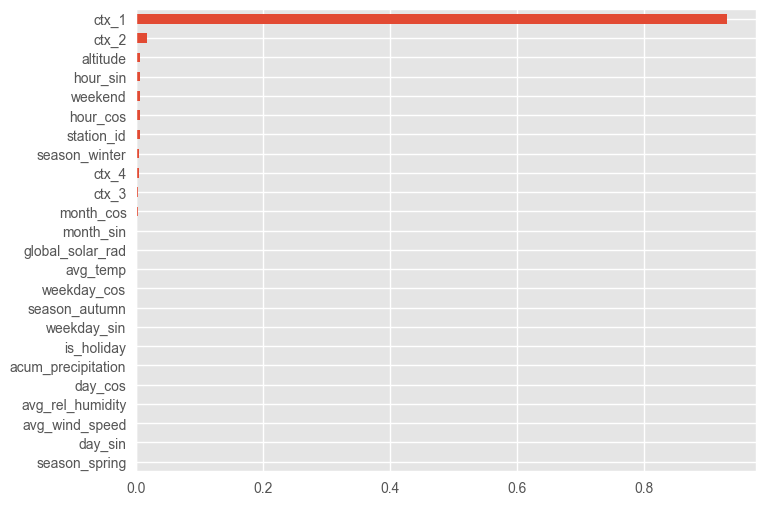

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
(pd.Series(xg.feature_importances_, index=X_train.columns)
 .sort_values()
 .plot.barh(ax=ax)
)

In [18]:
results = xg.evals_result()
JSON(results)

<IPython.core.display.JSON object>

Text(0, 0.5, 'rsme')

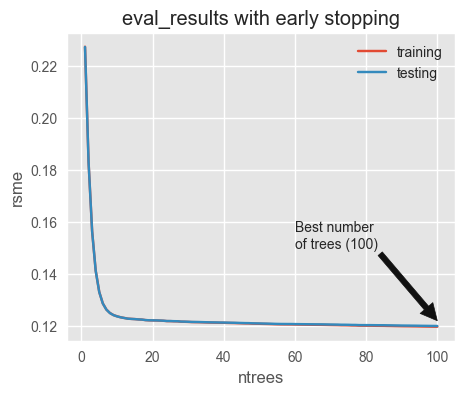

In [19]:
ax = (pd.DataFrame({'training': results['validation_0']['rmse'],
                   'testing': results['validation_1']['rmse']})
      .assign(ntrees=lambda tree: range(1, len(tree)+1))
      .set_index('ntrees')
      .plot(figsize=(5, 4), title='eval_results with early stopping')
      
      )
ax.annotate('Best number \nof trees (100)', xy=(100, 0.122),
            xytext=(60, 0.15), arrowprops={'color': 'k'})
ax.set_ylabel('rsme')

In [20]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
dtr.score(X_test, y_test)

0.5946048808597696

<Axes: >

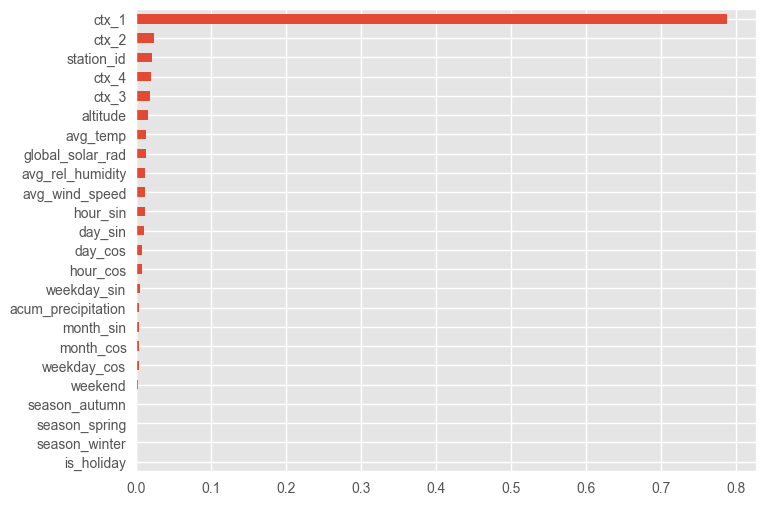

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
(pd.Series(dtr.feature_importances_, index=X_train.columns)
 .sort_values()
 .plot.barh(ax=ax)
)

In [24]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=3)
rfr.fit(X_train, y_train)
rfr.score(X_test, y_test)

0.7342064958511754

<Axes: >

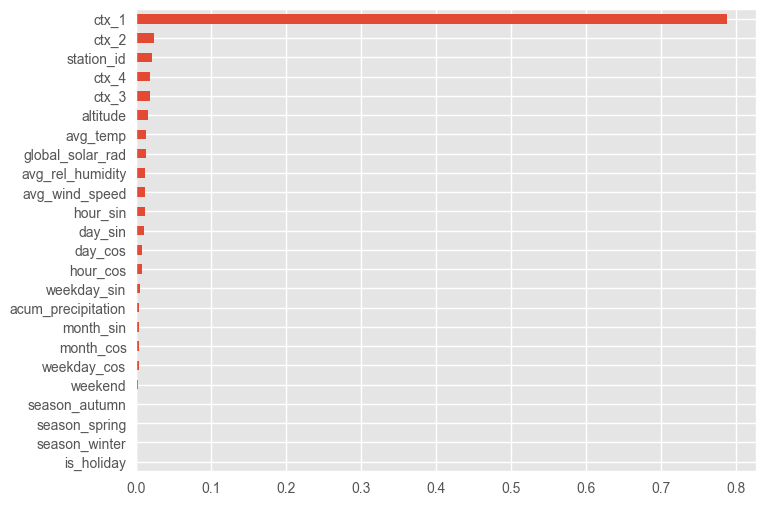

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
(pd.Series(rfr.feature_importances_, index=X_train.columns)
 .sort_values()
 .plot.barh(ax=ax)
)

In [46]:
def get_rawX_y(df, y_col, drop_set):
    raw = (df
           .set_index('year')
           .drop(index=drop_set)
           .reset_index()
          )
    return raw.drop(columns=['year', y_col]), raw[y_col]

drop_sets = [[2019, 2020], 2019, 2020, []]

for drop_set in drop_sets:
    
    bicing_X, bicing_y = get_rawX_y(bicing, 'percentage_docks_available', drop_set)

    X_raw_train, X_raw_test, y_train, y_test = train_test_split(
        bicing_X, bicing_y, shuffle=True, random_state=42
    )

    X_train = bicing_pl.fit_transform(X_raw_train, y_train)
    X_test = bicing_pl.transform(X_raw_test)
    
    print(f'- Drop set: {drop_set}')
    print('-' * 80)
    print('\n')
    
    xg = xgb.XGBRegressor(early_stopping_rounds=45)
    xg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=10)
    xg.score(X_test, y_test)
    
    print(f'Best rsme score: {xg.best_score}')
    print('=' * 80)
    print('\n')
    
    

- Drop set: [2019, 2020]
--------------------------------------------------------------------------------


[0]	validation_0-rmse:0.22741	validation_1-rmse:0.22730
[10]	validation_0-rmse:0.12333	validation_1-rmse:0.12331
[20]	validation_0-rmse:0.12210	validation_1-rmse:0.12212
[30]	validation_0-rmse:0.12147	validation_1-rmse:0.12154
[40]	validation_0-rmse:0.12116	validation_1-rmse:0.12126
[50]	validation_0-rmse:0.12078	validation_1-rmse:0.12092
[60]	validation_0-rmse:0.12052	validation_1-rmse:0.12068
[70]	validation_0-rmse:0.12032	validation_1-rmse:0.12052
[80]	validation_0-rmse:0.12008	validation_1-rmse:0.12030
[90]	validation_0-rmse:0.11988	validation_1-rmse:0.12013
[99]	validation_0-rmse:0.11969	validation_1-rmse:0.11997
Best rsme score: 0.11997353160398276


- Drop set: 2019
--------------------------------------------------------------------------------


[0]	validation_0-rmse:0.22702	validation_1-rmse:0.22698
[10]	validation_0-rmse:0.12302	validation_1-rmse:0.12311
[20]	validatio

In [50]:
xg.best_score

0.12131256083056063

In [52]:
from src.utils import save_object, load_object

save_object(r'..\models\model.pkl', xg)

In [49]:
best_model = load_object(r'..\models\model.pkl')
best_model.best_score

0.12131256083056063